<center><font size="10"> 🔥Transfer Learning🔥 </font></center>

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [7]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [8]:
tf.random.set_seed(42)
np.random.seed(42)
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))


model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])


history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.5642 - accuracy: 0.8164 - val_loss: 0.3875 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 10s 7ms/step - loss: 0.3555 - accuracy: 0.8740 - val_loss: 0.3285 - val_accuracy: 0.8859
Epoch 3/20
1375/1375 [==============================] - 11s 8ms/step - loss: 0.3179 - accuracy: 0.8869 - val_loss: 0.3025 - val_accuracy: 0.8956
Epoch 4/20
1375/1375 [==============================] - 10s 8ms/step - loss: 0.2979 - accuracy: 0.8968 - val_loss: 0.2876 - val_accuracy: 0.9033
Epoch 5/20
1375/1375 [==============================] - 10s 7ms/step - loss: 0.2847 - accuracy: 0.9010 - val_loss: 0.2787 - val_accuracy: 0.9076
Epoch 6/20
1375/1375 [==============================] - 11s 8ms/step - loss: 0.2752 - accuracy: 0.9051 - val_loss: 0.2734 - val_accuracy: 0.9088
Epoch 7/20
1375/1375 [==============================] - 11s 8ms/step - loss: 0.2671 - accuracy: 0.9088 - val_loss: 0.2711 - val_acc

In [9]:
model_A.save("model_for_reuse.h5")

In [10]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [11]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [12]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                        validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 60ms/step - loss: 0.8847 - accuracy: 0.5100 - val_loss: 0.5043 - val_accuracy: 0.7951
Epoch 2/20
7/7 [==============================] - 0s 29ms/step - loss: 0.4339 - accuracy: 0.8600 - val_loss: 0.3902 - val_accuracy: 0.8661
Epoch 3/20
7/7 [==============================] - 0s 31ms/step - loss: 0.3382 - accuracy: 0.9100 - val_loss: 0.3219 - val_accuracy: 0.9077
Epoch 4/20
7/7 [==============================] - 0s 25ms/step - loss: 0.2783 - accuracy: 0.9300 - val_loss: 0.2771 - val_accuracy: 0.9300
Epoch 5/20
7/7 [==============================] - 0s 24ms/step - loss: 0.2375 - accuracy: 0.9450 - val_loss: 0.2437 - val_accuracy: 0.9381
Epoch 6/20
7/7 [==============================] - 0s 28ms/step - loss: 0.2067 - accuracy: 0.9450 - val_loss: 0.2186 - val_accuracy: 0.9554
Epoch 7/20
7/7 [==============================] - 0s 39ms/step - loss: 0.1835 - accuracy: 0.9750 - val_loss: 0.2025 - val_accuracy: 0.9533
Epoch 8/20
7/7 [===========

In [13]:
model_A = keras.models.load_model("model_for_reuse.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation = 'sigmoid'))

#### To avoid the training affect model_A create its clone

In [14]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

#### As the output layer was randomly initialized the model might incur very large errors so to avoid it freeze training those reused layers for few epochs

In [15]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", metrics=['accuracy'])

In [16]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr = 1e-4)
model_B_on_A.compile(loss="binary_crossentropy", optimizer = optimizer, metrics=['accuracy'])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                            validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 66ms/step - loss: 0.4947 - accuracy: 0.7500 - val_loss: 0.3206 - val_accuracy: 0.7921
Epoch 2/4
7/7 [==============================] - 0s 29ms/step - loss: 0.2360 - accuracy: 0.8850 - val_loss: 0.2032 - val_accuracy: 0.9574
Epoch 3/4
7/7 [==============================] - 0s 28ms/step - loss: 0.1530 - accuracy: 0.9850 - val_loss: 0.1501 - val_accuracy: 0.9797
Epoch 4/4
7/7 [==============================] - 0s 32ms/step - loss: 0.1136 - accuracy: 0.9950 - val_loss: 0.1186 - val_accuracy: 0.9848
Epoch 1/16


c:\Users\unnikris\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/7 [==============================] - 1s 72ms/step - loss: 0.0948 - accuracy: 0.9950 - val_loss: 0.1164 - val_accuracy: 0.9858
Epoch 2/16
7/7 [==============================] - 0s 31ms/step - loss: 0.0927 - accuracy: 0.9950 - val_loss: 0.1145 - val_accuracy: 0.9858
Epoch 3/16
7/7 [==============================] - 0s 32ms/step - loss: 0.0909 - accuracy: 0.9950 - val_loss: 0.1127 - val_accuracy: 0.9868
Epoch 4/16
7/7 [==============================] - 0s 29ms/step - loss: 0.0893 - accuracy: 0.9950 - val_loss: 0.1107 - val_accuracy: 0.9868
Epoch 5/16
7/7 [==============================] - 0s 32ms/step - loss: 0.0874 - accuracy: 0.9950 - val_loss: 0.1090 - val_accuracy: 0.9868
Epoch 6/16
7/7 [==============================] - 0s 34ms/step - loss: 0.0858 - accuracy: 0.9950 - val_loss: 0.1074 - val_accuracy: 0.9868
Epoch 7/16
7/7 [==============================] - 0s 31ms/step - loss: 0.0843 - accuracy: 0.9950 - val_loss: 0.1057 - val_accuracy: 0.9868
Epoch 8/16
7/7 [======================

In [17]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0970 - accuracy: 0.9830


[0.09704770892858505, 0.9829999804496765]

## Faster Optimizers

### Momentum optimization

In [18]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

#### Nesterov Accelerated Gradient (faster than Momentum optimization)

In [20]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

#### AdaGrad (do not use for NN)

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=0.001)

#### RMSProp

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

#### Adam Optimization

In [22]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### Adamax Optimization

In [23]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### Nadam Optimization

In [24]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [27]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [28]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

## Learning Rate Scheduling

### Power Scheduling

In [25]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay = 1e-4)

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [29]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4838 - accuracy: 0.8288 - val_loss: 0.3995 - val_accuracy: 0.8600
Epoch 2/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3787 - accuracy: 0.8639 - val_loss: 0.3689 - val_accuracy: 0.8696
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3462 - accuracy: 0.8761 - val_loss: 0.3682 - val_accuracy: 0.8686
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3256 - accuracy: 0.8821 - val_loss: 0.3472 - val_accuracy: 0.8796
Epoch 5/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3107 - accuracy: 0.8895 - val_loss: 0.3404 - val_accuracy: 0.8750
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2970 - accuracy: 0.8943 - val_loss: 0.3387 - val_accuracy: 0.8798
Epoch 7/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2869 - accuracy: 0.8987 - val_loss: 0.3346 - val_accuracy:

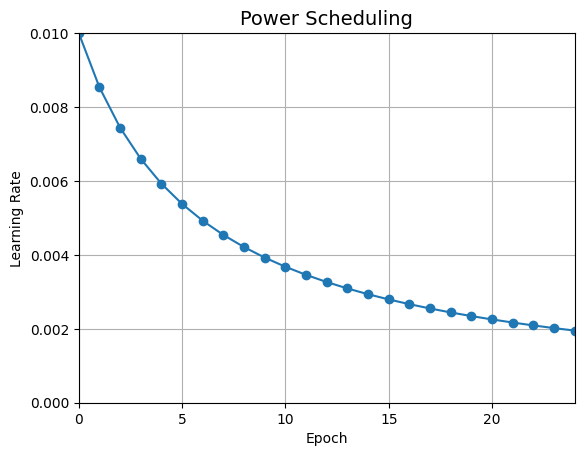

In [30]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

In [31]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.001, s=20)

In [34]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [35]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks = [lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4757 - accuracy: 0.8352 - val_loss: 0.3640 - val_accuracy: 0.8674 - lr: 0.0010
Epoch 2/25
1719/1719 [==============================] - 16s 10ms/step - loss: 0.3353 - accuracy: 0.8787 - val_loss: 0.3782 - val_accuracy: 0.8670 - lr: 8.9125e-04
Epoch 3/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2887 - accuracy: 0.8931 - val_loss: 0.3285 - val_accuracy: 0.8830 - lr: 7.9433e-04
Epoch 4/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2574 - accuracy: 0.9033 - val_loss: 0.3161 - val_accuracy: 0.8872 - lr: 7.0795e-04
Epoch 5/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2277 - accuracy: 0.9150 - val_loss: 0.3107 - val_accuracy: 0.8950 - lr: 6.3096e-04
Epoch 6/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2029 - accuracy: 0.9237 - val_loss: 0.3187 - val_accuracy: 0.8928 - lr: 5.6234e-04
Epoch 7/25
1719/1719 [=========

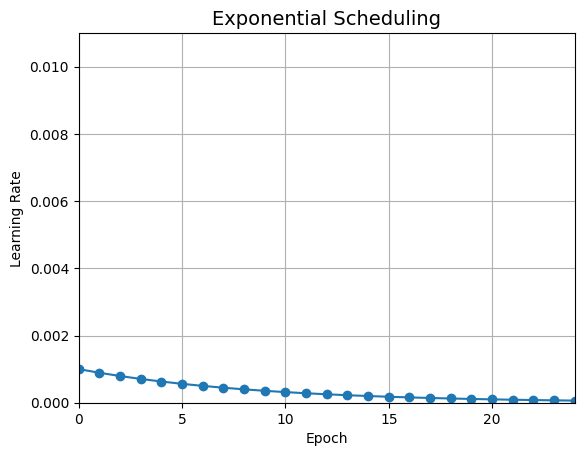

In [36]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 1Cycle scheduling

In [54]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [55]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

430/430 [==============================] - 3s 6ms/step - loss: nan - accuracy: 0.3955


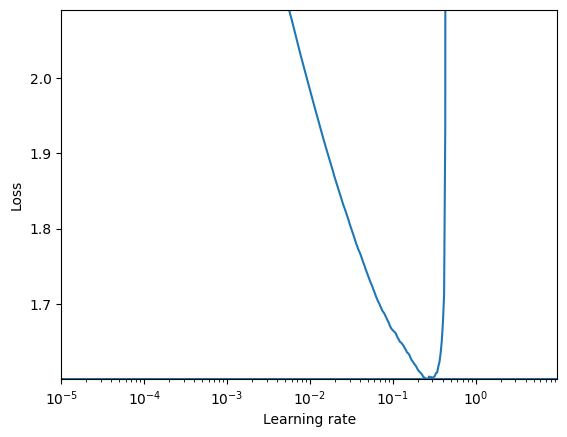

In [57]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [58]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                    self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                    self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [59]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 3s 6ms/step - loss: 0.6463 - accuracy: 0.7791 - val_loss: 0.4851 - val_accuracy: 0.8332
Epoch 2/25
430/430 [==============================] - 3s 6ms/step - loss: 0.4527 - accuracy: 0.8418 - val_loss: 0.4295 - val_accuracy: 0.8538
Epoch 3/25
430/430 [==============================] - 2s 6ms/step - loss: 0.4083 - accuracy: 0.8557 - val_loss: 0.4153 - val_accuracy: 0.8540
Epoch 4/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3798 - accuracy: 0.8659 - val_loss: 0.3837 - val_accuracy: 0.8638
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3594 - accuracy: 0.8728 - val_loss: 0.3717 - val_accuracy: 0.8702
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3407 - accuracy: 0.8796 - val_loss: 0.3676 - val_accuracy: 0.8752
Epoch 7/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3274 - accuracy: 0.8825 - val_loss: 0.3539 - val_accuracy: 0.8752
Epoch 

## Avoiding Overfitting Through Regularization

#### $l_1$ and $l_2$ Regularization

In [39]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                        kernel_initializer="he_normal",
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                        kernel_initializer="he_normal",
                        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                        kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 20
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid), callbacks = [early_stopping_cb])

Epoch 1/20
1719/1719 [==============================] - 19s 11ms/step - loss: 1.6135 - accuracy: 0.8110 - val_loss: 0.7218 - val_accuracy: 0.8308
Epoch 2/20
1719/1719 [==============================] - 20s 12ms/step - loss: 0.7199 - accuracy: 0.8274 - val_loss: 0.6848 - val_accuracy: 0.8374
Epoch 3/20
1719/1719 [==============================] - 18s 11ms/step - loss: 0.7027 - accuracy: 0.8321 - val_loss: 0.7003 - val_accuracy: 0.8366
Epoch 4/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.6969 - accuracy: 0.8356 - val_loss: 0.6768 - val_accuracy: 0.8438
Epoch 5/20
1719/1719 [==============================] - 17s 10ms/step - loss: 0.6925 - accuracy: 0.8369 - val_loss: 0.6648 - val_accuracy: 0.8496
Epoch 6/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.6899 - accuracy: 0.8373 - val_loss: 0.6653 - val_accuracy: 0.8524
Epoch 7/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.6882 - accuracy: 0.8393 - val_loss: 0.6633 - 

In [44]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                            activation = "elu",
                            kernel_initializer = 'he_normal',
                            kernel_regularizer = keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation = 'softmax', kernel_initializer = 'glorot_uniform')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 18s 10ms/step - loss: 1.6580 - accuracy: 0.8120 - val_loss: 0.7125 - val_accuracy: 0.8352
Epoch 2/2
1719/1719 [==============================] - 18s 11ms/step - loss: 0.7173 - accuracy: 0.8274 - val_loss: 0.6787 - val_accuracy: 0.8392


### Dropout

In [45]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5710 - accuracy: 0.8051 - val_loss: 0.3611 - val_accuracy: 0.8662
Epoch 2/2
1719/1719 [==============================] - 16s 10ms/step - loss: 0.4212 - accuracy: 0.8440 - val_loss: 0.3424 - val_accuracy: 0.8702


### Alpha Dropout

In [46]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20

In [47]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid), callbacks = [early_stopping_cb])

Epoch 1/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6617 - accuracy: 0.7603 - val_loss: 0.5722 - val_accuracy: 0.8490
Epoch 2/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5563 - accuracy: 0.7954 - val_loss: 0.5656 - val_accuracy: 0.8460
Epoch 3/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5258 - accuracy: 0.8045 - val_loss: 0.5044 - val_accuracy: 0.8596
Epoch 4/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5048 - accuracy: 0.8140 - val_loss: 0.4557 - val_accuracy: 0.8614
Epoch 5/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4886 - accuracy: 0.8185 - val_loss: 0.4479 - val_accuracy: 0.8620
Epoch 6/20
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4822 - accuracy: 0.8209 - val_loss: 0.4527 - val_accuracy: 0.8652
Epoch 7/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4667 - accuracy: 0.8257 - val_loss: 0.4798 - val_ac

### MC Dropout

In [48]:
y_probas = np.stack([model(X_test_scaled, training=True)
                    for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [49]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 86ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [50]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.01, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.12, 0.  , 0.81]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.04, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.14, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.08, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.13, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.24, 0.  , 0.74]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.09, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.2 , 0.  , 0

In [51]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.1 , 0.  , 0.88]],
      dtype=float32)

In [52]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.13, 0.  , 0.14]],
      dtype=float32)

In [53]:
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8621